<a href="https://colab.research.google.com/github/ahwarkhan/DL-IID/blob/main/DL_IID_with_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=d1dbce169a4e7ab622fa1d45524b0d71db7a45ce2ab4097154f4e651b858a5ca
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import psutil
import time
import random
import math
import lime
import lime.lime_tabular

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/research_paper/dataset/datatest_7_features_1.csv')

In [ ]:
dataset.describe().T

count         mean        std          min          25%  \
2318.4402090840676  44999.0  2400.084634  48.239944  2199.611246  2367.560809   
0.9095661384526199  44999.0     0.008632   3.019591   -13.191679    -2.025444   
-4.139311139656056  44999.0     0.008600   3.004335   -12.668148    -2.024688   
18.89359354792485   44999.0    -0.043499  10.031000   -54.216931    -6.799410   
5.472066192108001   44999.0    -0.260803  40.034246  -155.600356   -27.102140   
0.3299564440962265  44999.0     0.002206   0.997296    -4.103489    -0.675812   
3.611043842811059   44999.0     0.050417   9.982634   -42.007679    -6.679235   

                            50%          75%          max  
2318.4402090840676  2400.045211  2432.608640  2596.367862  
0.9095661384526199    -0.003796     2.035190    12.358836  
-4.139311139656056     0.017977     2.033905    13.023745  
18.89359354792485     -0.069868     6.672912    38.731440  
5.472066192108001      0.081334    26.507046   168.057708  
0.3299564440962265    -0.003181     0.672637     4.535973  
3.611043842811059      0.011707     6.794519    39.439889

In [ ]:
dataset.head()

2318.4402090840676  0.9095661384526199  -4.139311139656056  \
0         2369.017404           -1.754597            1.313440   
1         2453.383691            1.088862           -1.227993   
2         2433.591570           -5.839638            3.705717   
3         2459.126812            2.903708            1.819649   
4         2389.078792            1.728807            6.556076   

   18.89359354792485  5.472066192108001  0.3299564440962265  3.611043842811059  
0           3.161897         -34.433554            1.110685         -18.044512  
1          -9.131891         -11.780860           -0.086343          -9.914807  
2           1.830827           5.159389            0.467818         -20.351105  
3           7.543625          27.984036            0.279439          12.624162  
4           6.190018         -34.167965           -0.798856          -7.729004

In [ ]:
dataset.shape

(44999, 7)

In [ ]:
dataset.isnull().sum()

2318.4402090840676    0
0.9095661384526199    0
-4.139311139656056    0
18.89359354792485     0
5.472066192108001     0
0.3299564440962265    0
3.611043842811059     0
dtype: int64

In [ ]:
from sklearn.cluster import KMeans

n_clusters = 2

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_clusters = kmeans.fit_predict(dataset)

dataset['cluster'] = df_clusters

print(dataset['cluster'].value_counts())

cluster
0    22593
1    22406
Name: count, dtype: int64


In [ ]:
dataset.to_csv('/content/drive/MyDrive/research_paper/dataset/clustered_dataset.csv', index=False)

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/research_paper/dataset/clustered_dataset.csv')

In [ ]:
dataset

2318.4402090840676  0.9095661384526199  -4.139311139656056  \
0             2369.017404           -1.754597            1.313440   
1             2453.383691            1.088862           -1.227993   
2             2433.591570           -5.839638            3.705717   
3             2459.126812            2.903708            1.819649   
4             2389.078792            1.728807            6.556076   
...                   ...                 ...                 ...   
44994         2450.296862           -0.649041            1.243733   
44995         2398.655102           -2.493205           -2.233277   
44996         2484.381901            1.244478           -0.711912   
44997         2423.099763           -4.303185            3.233872   
44998         2381.570707            0.006850           -3.105187   

       18.89359354792485  5.472066192108001  0.3299564440962265  \
0               3.161897         -34.433554            1.110685   
1              -9.131891         -11.780860           -0.086343   
2               1.830827           5.159389            0.467818   
3               7.543625          27.984036            0.279439   
4               6.190018         -34.167965           -0.798856   
...                  ...                ...                 ...   
44994          26.162420          76.204476            2.071091   
44995          -1.816925           6.189116            0.039580   
44996          13.597908          17.765552            0.775678   
44997          -5.600552          -7.484681            1.682838   
44998          13.235655         -21.380933            0.616066   

       3.611043842811059  cluster  
0             -18.044512        0  
1              -9.914807        1  
2             -20.351105        1  
3              12.624162        1  
4              -7.729004        0  
...                  ...      ...  
44994          25.522839        1  
44995          -8.127218        0  
44996          -8.039027        1  
44997           8.371839        1  
44998           2.091933        0  

[44999 rows x 8 columns]

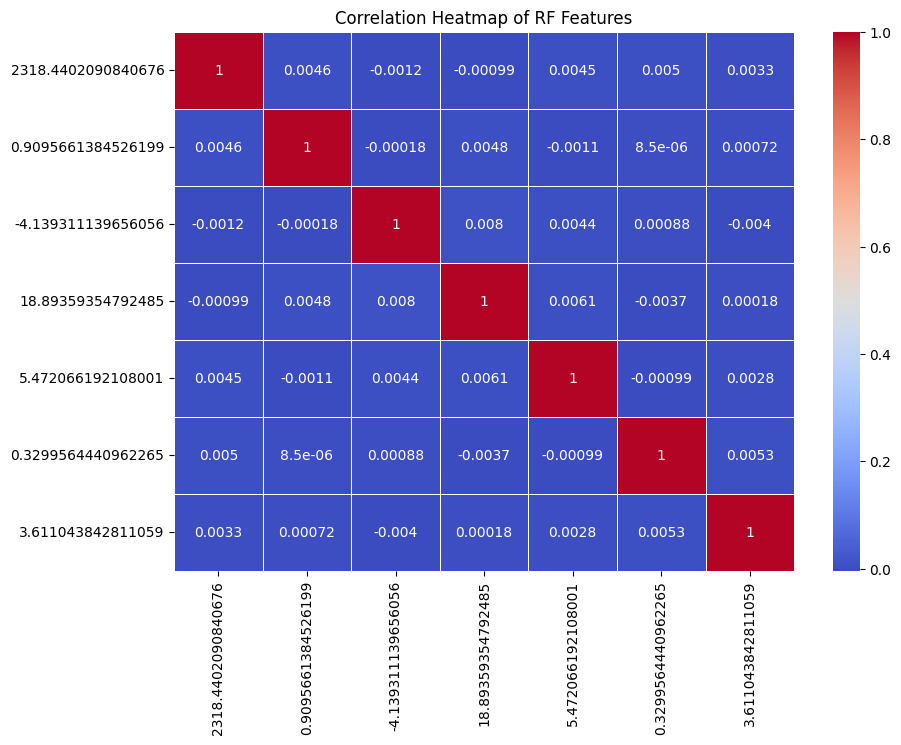

In [ ]:
import seaborn as sns

correlation_matrix = dataset.drop(['cluster'], axis=1).corr()

plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

plt.title("Correlation Heatmap of RF Features", size=12)

plt.show()

In [ ]:
X = dataset.drop(['cluster'], axis=1)
y = dataset['cluster']

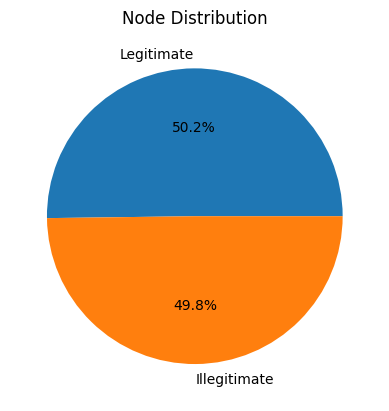

In [ ]:
graph_labels = 'Legitimate', 'Illegitimate'
graph_y = y.value_counts()
fig, ax = plt.subplots()
ax.pie(graph_y, labels=graph_labels, autopct='%1.1f%%')
plt.title('Node Distribution')
plt.show()

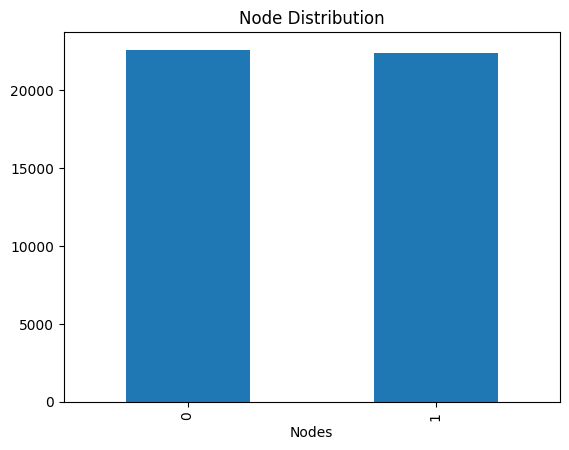

In [ ]:
graph_y.plot(kind='bar', xlabel='Nodes')
plt.title('Node Distribution')
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [ ]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        assert len(self.X) == len(self.y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y.iloc[idx]
        return x, y

In [ ]:
train_dataset = MyDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = MyDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
val_dataset = MyDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### DNN-BiLSTM

In [ ]:
class DNNBiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, lstm_layers, output_size):
        super(DNNBiLSTM, self).__init__()

        self.fc1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()

        self.lstm = nn.LSTM(input_size=64, hidden_size=hidden_size,
                            num_layers=lstm_layers, batch_first=True,
                            bidirectional=True)

        self.fc3 = nn.Linear(hidden_size * 2, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.float()
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = x.unsqueeze(1)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]

        x = self.fc3(lstm_out)
        return self.softmax(x)

    def predict_proba(self, x):
      with torch.no_grad():
          x = torch.tensor(x, dtype=torch.float32)
          output = self.forward(x)
          probabilities = F.softmax(output, dim=1).numpy()
          return probabilities

In [ ]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss, correct_train, total_samples = 0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        train_loss = total_train_loss / len(train_loader)
        train_accuracy = (correct_train / total_samples) * 100

        # Validation Phase
        model.eval()
        total_val_loss, correct_val, total_val_samples = 0, 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                total_val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val_samples += labels.size(0)

        val_loss = total_val_loss / len(val_loader)
        val_accuracy = (correct_val / total_val_samples) * 100

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Train Acc: {train_accuracy:.2f}% | Val Acc: {val_accuracy:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
def plot_performance(train_losses, val_losses, train_acc, val_acc):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Loss Plot
    axes[0].plot(train_losses, label="Train Loss", color='blue')
    axes[0].plot(val_losses, label="Validation Loss", color='red')
    axes[0].set_title("Loss Curve")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    # Accuracy Plot
    axes[1].plot(train_acc, label="Train Accuracy", color='blue')
    axes[1].plot(val_acc, label="Validation Accuracy", color='red')
    axes[1].set_title("Accuracy Curve")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy (%)")
    axes[1].legend()

    plt.show()

In [ ]:
input_size = X_train.shape[1]
hidden_size = 64
lstm_layers = 1
output_size = 2
batch_size = 128
num_epochs = 20
learning_rate = 0.0001

In [ ]:
model = DNNBiLSTM(input_size, hidden_size, lstm_layers, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
train_losses, val_losses, train_acc, val_acc = train(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch 1/20 | Train Loss: 0.4856 | Val Loss: 0.3510 | Train Acc: 93.31% | Val Acc: 98.26%
Epoch 2/20 | Train Loss: 0.3398 | Val Loss: 0.3335 | Train Acc: 98.43% | Val Acc: 98.65%
Epoch 3/20 | Train Loss: 0.3304 | Val Loss: 0.3281 | Train Acc: 98.80% | Val Acc: 99.04%
Epoch 4/20 | Train Loss: 0.3271 | Val Loss: 0.3256 | Train Acc: 98.96% | Val Acc: 99.15%
Epoch 5/20 | Train Loss: 0.3250 | Val Loss: 0.3239 | Train Acc: 99.03% | Val Acc: 99.22%
Epoch 6/20 | Train Loss: 0.3236 | Val Loss: 0.3232 | Train Acc: 99.14% | Val Acc: 99.22%
Epoch 7/20 | Train Loss: 0.3225 | Val Loss: 0.3225 | Train Acc: 99.22% | Val Acc: 99.15%
Epoch 8/20 | Train Loss: 0.3216 | Val Loss: 0.3210 | Train Acc: 99.27% | Val Acc: 99.47%
Epoch 9/20 | Train Loss: 0.3209 | Val Loss: 0.3238 | Train Acc: 99.34% | Val Acc: 98.90%
Epoch 10/20 | Train Loss: 0.3202 | Val Loss: 0.3197 | Train Acc: 99.36% | Val Acc: 99.49%
Epoch 11/20 | Train Loss: 0.3196 | Val Loss: 0.3206 | Train Acc: 99.40% | Val Acc: 99.33%
Epoch 12/20 | Train

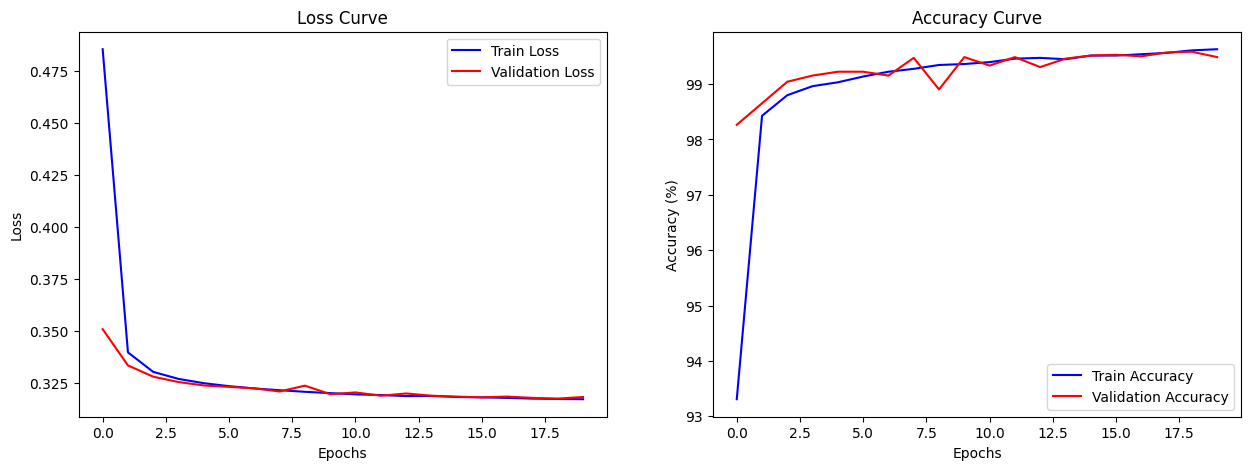

In [ ]:
plot_performance(train_losses, val_losses, train_acc, val_acc)

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    predictions = []
    labels = []

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device, dtype=torch.float32), y.to(device, dtype=torch.long)
            outputs = model(x)
            loss = criterion(outputs, y)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y).sum().item()

            predictions.extend(predicted.cpu().numpy())
            labels.extend(y.cpu().numpy())

    # Convert to numpy arrays
    labels_array = np.array(labels)
    predictions_array = np.array(predictions)

    # Compute evaluation metrics
    accuracy = correct / len(test_loader.dataset)
    precision = precision_score(labels, predictions, zero_division=False)
    recall = recall_score(labels, predictions, zero_division=False)
    f1 = f1_score(labels, predictions, zero_division=False)

    # Compute error metrics
    MSE = mean_squared_error(labels_array, predictions_array)
    RMSE = np.sqrt(MSE)
    MAE = mean_absolute_error(labels_array, predictions_array)

    safe_labels = np.where(labels_array == 0, np.nan, labels_array)
    MAPE = np.nanmean(np.abs((labels_array - predictions_array) / safe_labels)) * 100

    # System Resource Utilization
    process = psutil.Process()
    cpu_utilization = psutil.cpu_percent(interval=1)
    memory_usage = process.memory_info().rss / 1024  # Convert to KB

    # Print Results
    print("\n--- Evaluation Metrics ---")
    print(f"Test Loss: {test_loss / len(test_loader):.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    print("\n--- Error Metrics ---")
    print(f"Mean Absolute Error (MAE): {MAE:.4f}")
    print(f"Mean Squared Error (MSE): {MSE:.4f}")
    print(f"Root Mean Squared Error (RMSE): {RMSE:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {MAPE:.2f}%")

    print("\n--- System Resource Utilization ---")
    print(f"CPU Utilization: {cpu_utilization}%")
    print(f"Memory Usage: {memory_usage:.2f} KB")

    # Print Classification Report
    print("\n--- Classification Report ---")
    print(classification_report(labels, predictions, target_names=['Legitimate (0)', 'Malicious (1)']))

    # Plot Confusion Matrix
    conf_matrix = confusion_matrix(labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Legitimate (0)', 'Malicious (1)'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


--- Evaluation Metrics ---
Test Loss: 0.3178
Test Accuracy: 0.9960
Precision: 0.9933
Recall: 0.9987
F1 Score: 0.9960

--- Error Metrics ---
Mean Absolute Error (MAE): 0.0040
Mean Squared Error (MSE): 0.0040
Root Mean Squared Error (RMSE): 0.0632
Mean Absolute Percentage Error (MAPE): 0.13%

--- System Resource Utilization ---
CPU Utilization: 3.5%
Memory Usage: 776492.00 KB

--- Classification Report ---
                precision    recall  f1-score   support

Legitimate (0)       1.00      0.99      1.00      4526
 Malicious (1)       0.99      1.00      1.00      4474

      accuracy                           1.00      9000
     macro avg       1.00      1.00      1.00      9000
  weighted avg       1.00      1.00      1.00      9000



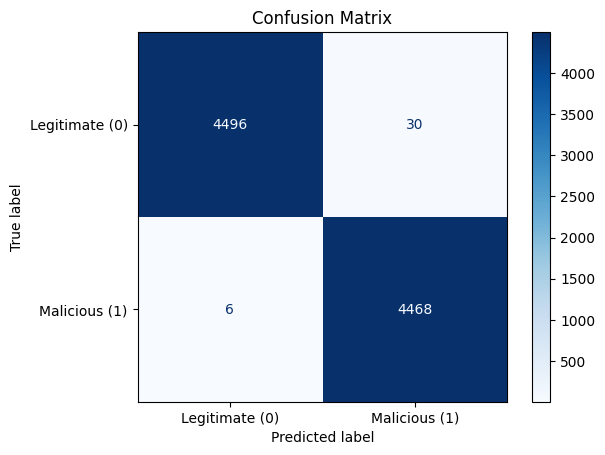

In [ ]:
evaluate_model(model, test_loader)

###Fitness (Objective) Function

In [ ]:
def train_on_selected_features(selected_features, X, y, epochs=50, batch_size=128):
    selected_features_indices = np.where(selected_features)[0]
    X_selected = X.iloc[:, selected_features_indices]

    scaler = StandardScaler()
    X_selected = scaler.fit_transform(X_selected)

    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    train_dataset1 = MyDataset(X_train, y_train)
    train_loader1 = DataLoader(train_dataset1, batch_size=64, shuffle=True)
    val_dataset1 = MyDataset(X_val, y_val)
    val_loader1 = DataLoader(val_dataset1, batch_size=64, shuffle=False)

    input_size = X_train.shape[1]
    hidden_size = 64
    lstm_layers = 1
    output_size = 2
    model = DNNBiLSTM(input_size, hidden_size, lstm_layers, output_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in train_loader1:
            x, y = batch
            y = y.long()
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        val_loss = 0
        correct = 0

        with torch.no_grad():
            for batch in val_loader1:
                x, y = batch
                y = y.long()
                outputs = model(x)
                loss = criterion(outputs, y)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == y).sum().item()

        accuracy = correct / len(val_dataset1)

        return 1 - accuracy

In [ ]:
class solution:
    def __init__(self):
        self.best = 0
        self.bestIndividual = []
        self.convergence = []
        self.optimizer = ""
        self.objfname = ""
        self.startTime = 0
        self.endTime = 0
        self.executionTime = 0
        self.lb = 0
        self.ub = 0
        self.dim = 0
        self.popnum = 0
        self.maxiers = 0

### GA

In [ ]:
def crossover(individualLength, parent1, parent2):
    crossover_point = random.randint(1, individualLength - 1)
    offspring1 = np.concatenate([parent1[:crossover_point], parent2[crossover_point:]])
    offspring2 = np.concatenate([parent2[:crossover_point], parent1[crossover_point:]])
    return offspring1, offspring2

In [ ]:
def mutation(individual, individualLength, lb, ub):
    mutationIndex = random.randint(0, individualLength - 1)
    individual[mutationIndex] = 1 - individual[mutationIndex]

In [ ]:
def pairSelection(population, scores, popSize):
    def rouletteWheelSelectionId(scores, popSize):
        total_fitness = sum(scores)
        normalized_scores = [score / total_fitness for score in scores]
        cumulative_probs = np.cumsum(normalized_scores)
        random_num = random.random()
        for i, cumulative_prob in enumerate(cumulative_probs):
            if random_num <= cumulative_prob:
                return i

    parent1Id = rouletteWheelSelectionId(scores, popSize)
    parent1 = population[parent1Id].copy()

    parent2Id = parent1Id
    while parent2Id == parent1Id:
        parent2Id = rouletteWheelSelectionId(scores, popSize)

    parent2 = population[parent2Id].copy()

    return parent1, parent2

In [ ]:
def mutatePopulaton(population, popSize, mutationProbability, keep, lb, ub):
    for i in range(keep, popSize):
        if random.random() < mutationProbability:
            mutation(population[i], len(population[i]), lb, ub)

In [ ]:
def sortPopulation(population, scores):
    sorted_indices = scores.argsort()
    population = population[sorted_indices]
    scores = scores[sorted_indices]
    return population, scores

In [ ]:
def crossoverPopulaton(population, scores, popSize, crossoverProbability, keep):
    newPopulation = np.zeros_like(population)
    newPopulation[:keep] = population[:keep]

    for i in range(keep, popSize, 2):
        parent1, parent2 = pairSelection(population, scores, popSize)
        individualLength = len(parent1)

        if random.random() < crossoverProbability:
            offspring1, offspring2 = crossover(individualLength, parent1, parent2)
        else:
            offspring1, offspring2 = parent1.copy(), parent2.copy()

        newPopulation[i] = offspring1
        if i + 1 < popSize:
            newPopulation[i + 1] = offspring2

    return newPopulation

In [ ]:
def clearDups(population, lb, ub):
    unique_population = np.unique(population, axis=0)
    num_duplicates = len(population) - len(unique_population)

    if num_duplicates > 0:
        random_individuals = np.random.randint(2, size=(num_duplicates, population.shape[1]))
        unique_population = np.vstack((unique_population, random_individuals))

    return unique_population

In [ ]:
def GA(objf, lb, ub, dim, popSize, iters):
    cp = 0.8
    mp = 0.05
    keep = 2
    s = solution()

    bestScore = float("inf")
    bestIndividual = None

    ga = np.random.randint(2, size=(popSize, dim))
    convergence_curve = np.zeros(iters)

    print('GA is optimizing "' + objf.__name__ + '" for feature selection')

    timerStart = time.time()
    s.startTime = time.strftime("%Y-%m-%d-%H-%M-%S")

    for l in range(iters):
        scores = np.array([objf(ind) for ind in ga])

        ga, scores = sortPopulation(ga, scores)

        if scores[0] < bestScore:
            bestScore = scores[0]
            bestIndividual = ga[0]

        convergence_curve[l] = bestScore

        if l % 1 == 0:
            print(f"Iteration {l + 1}, best fitness (error): {bestScore:.4f}")

        ga = crossoverPopulaton(ga, scores, popSize, cp, keep)
        mutatePopulaton(ga, popSize, mp, keep, lb, ub)
        ga = clearDups(ga, lb, ub)

    timerEnd = time.time()
    s.bestIndividual = bestIndividual
    s.bestScore = bestScore
    s.executionTime = timerEnd - timerStart
    s.convergence = convergence_curve
    s.optimizer = "GA"
    s.objfname = objf.__name__

    return s

In [ ]:
dim = X.shape[1]
lb = [0] * dim
ub = [1] * dim
popSize = 20
iters = 5

In [ ]:
def objective(selected_features):
  return train_on_selected_features(selected_features, X, y)

In [ ]:
best_solution = GA(objective, lb, ub, dim, popSize, iters)

print(f"Best feature set: {best_solution.bestIndividual}")
print(f"Best accuracy (1 - best error): {1 - best_solution.bestScore}")

GA is optimizing "objective" for feature selection
Iteration 1, best fitness (error): 0.0029
Iteration 2, best fitness (error): 0.0026
Iteration 3, best fitness (error): 0.0026
Iteration 4, best fitness (error): 0.0026
Iteration 5, best fitness (error): 0.0026
Best feature set: [1 0 0 0 1 0 0]
Best accuracy (1 - best error): 0.9973611111111111


In [ ]:
selected_features_ga = best_solution.bestIndividual

In [ ]:
selected_features_ga

array([1, 0, 0, 0, 1, 0, 0])

In [ ]:
selected_features_ga_original = [X.columns[i] for i, x in enumerate(selected_features_ga) if x == 1]
print(selected_features_ga_original)
print(len(selected_features_ga_original))

['2318.4402090840676', '5.472066192108001']
2


In [ ]:
weights_ga = [1 if x in selected_features_ga_original else 0 for x in X.columns]
print(weights_ga)

[1, 0, 0, 0, 1, 0, 0]


### GA Features

In [ ]:
ga_features_indices = [X.columns.get_loc(col) for col in selected_features_ga_original]

In [ ]:
X_selected_ga = X.iloc[:, ga_features_indices]

In [ ]:
X_train_selected_ga, X_test_selected_ga, y_train_selected_ga, y_test_selected_ga = train_test_split(X_selected_ga, y, test_size=0.3, random_state=42)
X_train_selected_ga, X_val_selected_ga, y_train_selected_ga, y_val_selected_ga = train_test_split(X_train_selected_ga, y_train_selected_ga, test_size=0.2, random_state=42)

In [ ]:
X_train_selected_ga = scaler.fit_transform(X_train_selected_ga)
X_test_selected_ga = scaler.transform(X_test_selected_ga)
X_val_selected_ga = scaler.transform(X_val_selected_ga)

In [ ]:
train_dataset_selected_ga = MyDataset(X_train_selected_ga, y_train_selected_ga)
train_loader_selected_ga = DataLoader(train_dataset_selected_ga, batch_size=64, shuffle=True)
test_dataset_selected_ga = MyDataset(X_test_selected_ga, y_test_selected_ga)
test_loader_selected_ga = DataLoader(test_dataset_selected_ga, batch_size=64, shuffle=False)
val_dataset_selected_ga = MyDataset(X_val_selected_ga, y_val_selected_ga)
val_loader_selected_ga = DataLoader(val_dataset_selected_ga, batch_size=64, shuffle=False)

In [ ]:
model_selected_ga = DNNBiLSTM(input_size=X_train_selected_ga.shape[1], hidden_size=64, lstm_layers=1, output_size=2)
criterion = nn.CrossEntropyLoss()
optimizer_selected_ga = optim.Adam(model_selected_ga.parameters(), lr=0.0001)

In [ ]:
train_losses_selected_ga, val_losses_selected_ga, train_acc_selected_ga, val_acc_selected_ga = train(model_selected_ga, train_loader_selected_ga, val_loader_selected_ga, criterion, optimizer_selected_ga)

Epoch 1/50 | Train Loss: 0.4777 | Val Loss: 0.3476 | Train Acc: 91.59% | Val Acc: 99.05%
Epoch 2/50 | Train Loss: 0.3336 | Val Loss: 0.3278 | Train Acc: 99.62% | Val Acc: 99.73%
Epoch 3/50 | Train Loss: 0.3248 | Val Loss: 0.3229 | Train Acc: 99.66% | Val Acc: 99.86%
Epoch 4/50 | Train Loss: 0.3217 | Val Loss: 0.3207 | Train Acc: 99.70% | Val Acc: 99.90%
Epoch 5/50 | Train Loss: 0.3201 | Val Loss: 0.3193 | Train Acc: 99.79% | Val Acc: 99.90%
Epoch 6/50 | Train Loss: 0.3190 | Val Loss: 0.3184 | Train Acc: 99.76% | Val Acc: 99.90%
Epoch 7/50 | Train Loss: 0.3184 | Val Loss: 0.3193 | Train Acc: 99.77% | Val Acc: 99.54%
Epoch 8/50 | Train Loss: 0.3176 | Val Loss: 0.3174 | Train Acc: 99.79% | Val Acc: 99.79%
Epoch 9/50 | Train Loss: 0.3172 | Val Loss: 0.3176 | Train Acc: 99.79% | Val Acc: 99.60%
Epoch 10/50 | Train Loss: 0.3171 | Val Loss: 0.3166 | Train Acc: 99.77% | Val Acc: 99.81%
Epoch 11/50 | Train Loss: 0.3165 | Val Loss: 0.3162 | Train Acc: 99.80% | Val Acc: 99.89%
Epoch 12/50 | Train

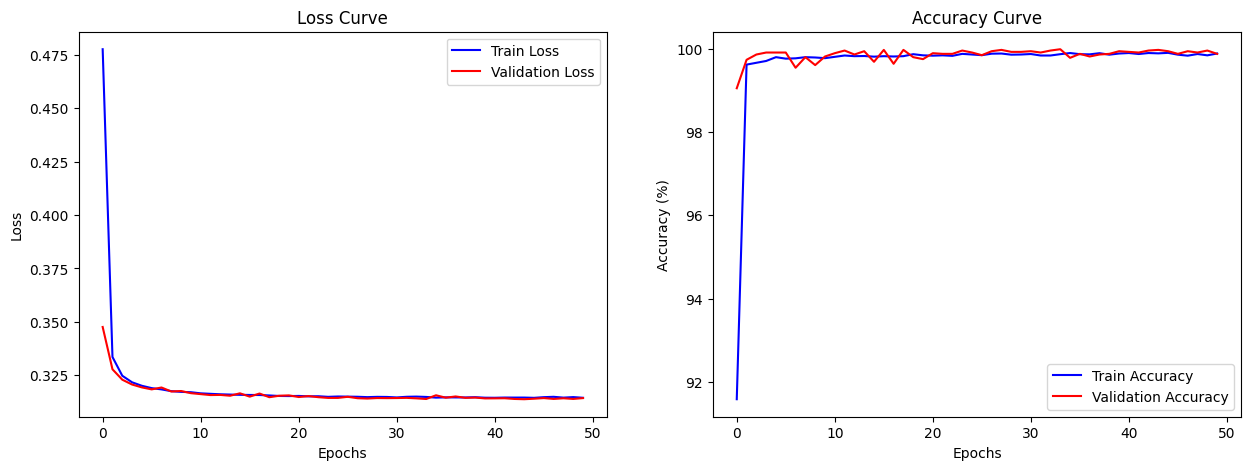

In [ ]:
plot_performance(train_losses_selected_ga, val_losses_selected_ga, train_acc_selected_ga, val_acc_selected_ga)


--- Evaluation Metrics ---
Test Loss: 0.3147
Test Accuracy: 0.9984
Precision: 1.0000
Recall: 0.9967
F1 Score: 0.9984

--- Error Metrics ---
Mean Absolute Error (MAE): 0.0016
Mean Squared Error (MSE): 0.0016
Root Mean Squared Error (RMSE): 0.0404
Mean Absolute Percentage Error (MAPE): 0.33%

--- System Resource Utilization ---
CPU Utilization: 9.0%
Memory Usage: 778072.00 KB

--- Classification Report ---
                precision    recall  f1-score   support

Legitimate (0)       1.00      1.00      1.00      6771
 Malicious (1)       1.00      1.00      1.00      6729

      accuracy                           1.00     13500
     macro avg       1.00      1.00      1.00     13500
  weighted avg       1.00      1.00      1.00     13500



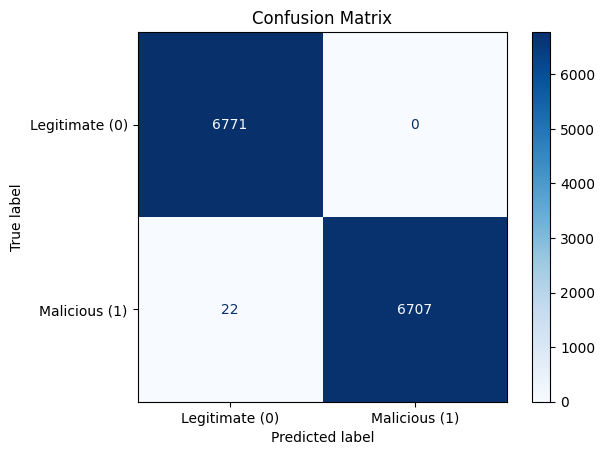

In [ ]:
evaluate_model(model_selected_ga, test_loader_selected_ga)

### LIME for DNN-BiLSTM with All Features

In [ ]:
explainer1 = lime.lime_tabular.LimeTabularExplainer(X_train,
                                                   feature_names=X.columns.tolist(),
                                                   mode='classification',
                                                   discretize_continuous=True)

In [ ]:
i = 10
exp1 = explainer1.explain_instance(
    data_row=X_test[i],
    predict_fn=model.predict_proba,
    num_features=X_train.shape[1]
)

In [ ]:
y_test_selected_ga.iloc[i]

0

In [ ]:
exp1.show_in_notebook(show_table=True, show_predicted_value=True)

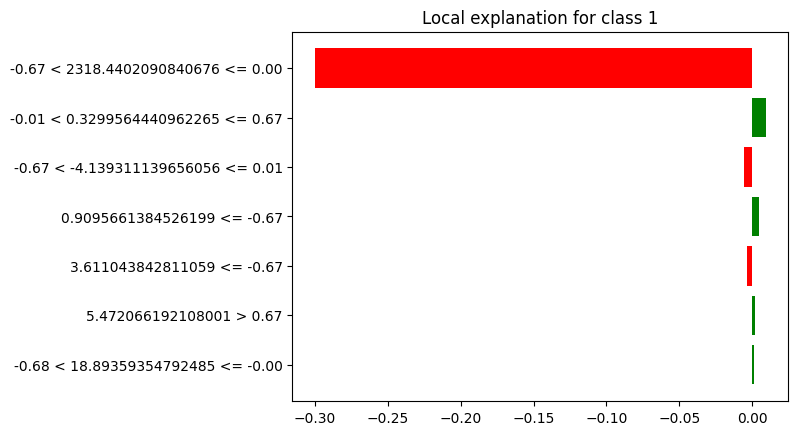

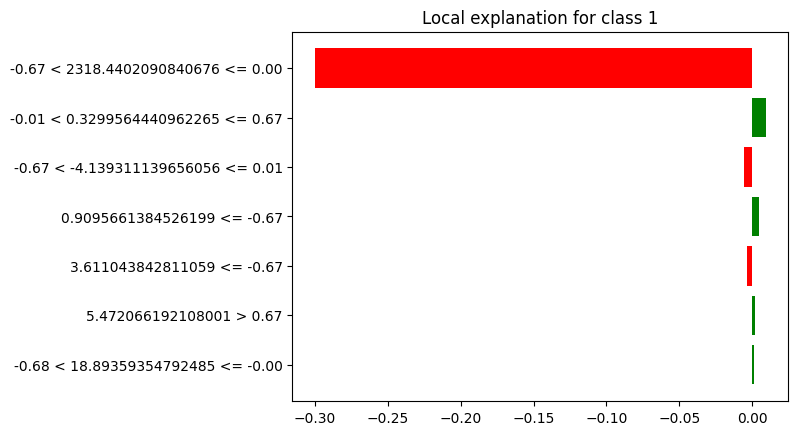

In [ ]:
exp1.as_pyplot_figure()

In [ ]:
exp1.save_to_file('/content/drive/MyDrive/research_paper/lime_explanation.html')

In [ ]:
feature_contributions1 = exp1.as_map()[1]
print("Feature Contributions (index-based):", feature_contributions1)

Feature Contributions (index-based): [(0, -0.30006099741400494), (5, 0.009420678635027022), (2, -0.005420290036767272), (1, 0.004513437313605833), (6, -0.0031818105176567787), (4, 0.002157042955219134), (3, 0.0011359452824968518)]


### LIME for DNN-BiLSTM with GA Features

In [ ]:
explainer2 = lime.lime_tabular.LimeTabularExplainer(X_train_selected_ga,
                                                   feature_names=X_selected_ga,
                                                   mode='classification',
                                                   discretize_continuous=True)

In [ ]:
j=10
exp2 = explainer2.explain_instance(
    data_row=X_test_selected_ga[j],
    predict_fn=model_selected_ga.predict_proba,
    num_features=X_train_selected_ga.shape[1]
)

In [ ]:
exp2.show_in_notebook(show_table=True, show_predicted_value=True)

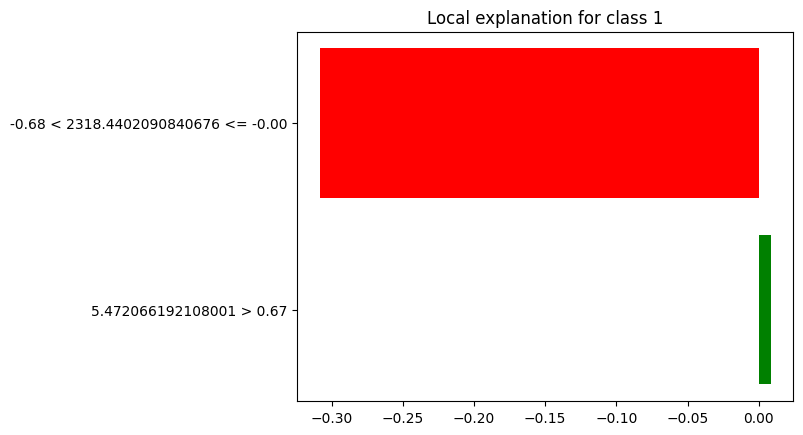

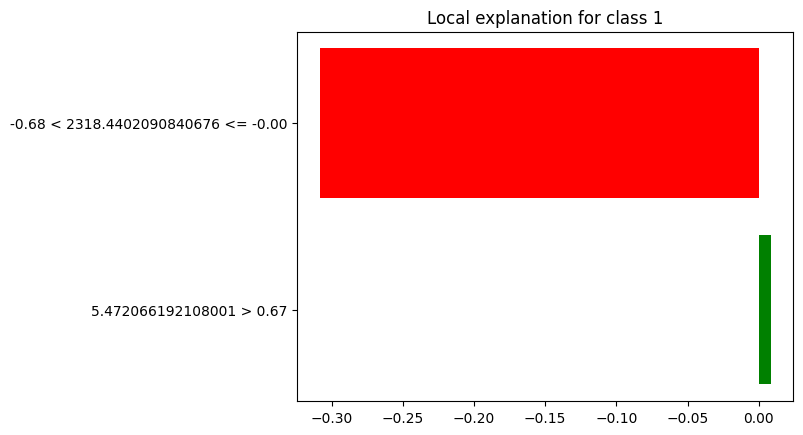

In [ ]:
exp2.as_pyplot_figure()

In [ ]:
exp2.save_to_file('/content/drive/MyDrive/research_paper/lime_explanation_ga.html')

In [ ]:
feature_contributions2 = exp2.as_map()[1]
print("Feature Contributions (index-based):", feature_contributions2)

Feature Contributions (index-based): [(0, -0.3082432543656863), (1, 0.008332742534036064)]


Model Size

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/research_paper/dnn_bilstm_model.pth')

model_size1 = os.path.getsize('/content/drive/MyDrive/research_paper/dnn_bilstm_model.pth') / 1024
print(f"Model Size: {model_size1:.2f} KB")

Model Size: 302.14 KB


In [ ]:
torch.save(model_selected_ga.state_dict(), '/content/drive/MyDrive/research_paper/ga_selected_model.pth')

model_size_ga = os.path.getsize('/content/drive/MyDrive/research_paper/ga_selected_model.pth') / 1024
print(f"Model Size: {model_size_ga:.2f} KB")

Model Size: 299.66 KB


### Dynamic Quantization model

In [ ]:
import torch.quantization
quantized_model_ga = torch.quantization.quantize_dynamic(
    model_selected_ga,
    {nn.LSTM},
    dtype=torch.qint8
)


--- Evaluation Metrics ---
Test Loss: 0.3147
Test Accuracy: 0.9984
Precision: 1.0000
Recall: 0.9969
F1 Score: 0.9984

--- Error Metrics ---
Mean Absolute Error (MAE): 0.0016
Mean Squared Error (MSE): 0.0016
Root Mean Squared Error (RMSE): 0.0394
Mean Absolute Percentage Error (MAPE): 0.31%

--- System Resource Utilization ---
CPU Utilization: 3.0%
Memory Usage: 795924.00 KB

--- Classification Report ---
                precision    recall  f1-score   support

Legitimate (0)       1.00      1.00      1.00      6771
 Malicious (1)       1.00      1.00      1.00      6729

      accuracy                           1.00     13500
     macro avg       1.00      1.00      1.00     13500
  weighted avg       1.00      1.00      1.00     13500



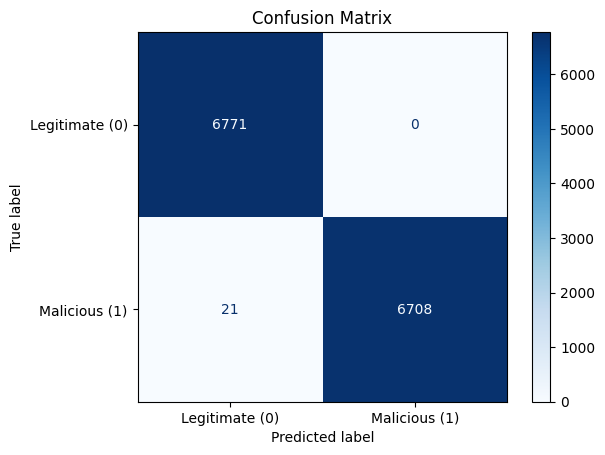

In [ ]:
evaluate_model(quantized_model_ga, test_loader_selected_ga)

In [ ]:
torch.save(quantized_model_ga.state_dict(), '/content/drive/MyDrive/research_paper/ga_quantised_model.pth')

quantized_ga_size = os.path.getsize('/content/drive/MyDrive/research_paper/ga_quantised_model.pth') / 1024
print(f"Model Size: {quantized_ga_size:.2f} KB")

Model Size: 108.42 KB
